<a href="https://colab.research.google.com/github/Abhishek3009/Brain-MRI-tumor-Segmentation/blob/main/SummaryAndOutput_BrainMriTumorSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

!chmod 600 /content/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip \*.zip
!rm *.zip

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, Convolution2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Add, Lambda, ReLU, LeakyReLU, concatenate
from tensorflow.keras.applications import MobileNetV2

from warnings import filterwarnings
filterwarnings('ignore')
import random
from glob import glob
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Set Parameters
im_width = 256
im_height = 256
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)

### **Data genertator, data augmentation and adjust data**

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

def model_result(model_name,df_test):
    for i in range(30):
        index=np.random.randint(1,len(df_test.index))
        img = cv2.imread(df_test['filename'].iloc[index])
        img = cv2.resize(img ,(im_height, im_width))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred= model_name.predict(img)

        plt.figure(figsize=(12,12))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
        plt.title('Original Mask')
        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.show()

In [ ]:
from tensorflow.keras import backend as K
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 0.001
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

## **Model 1 - Unet**

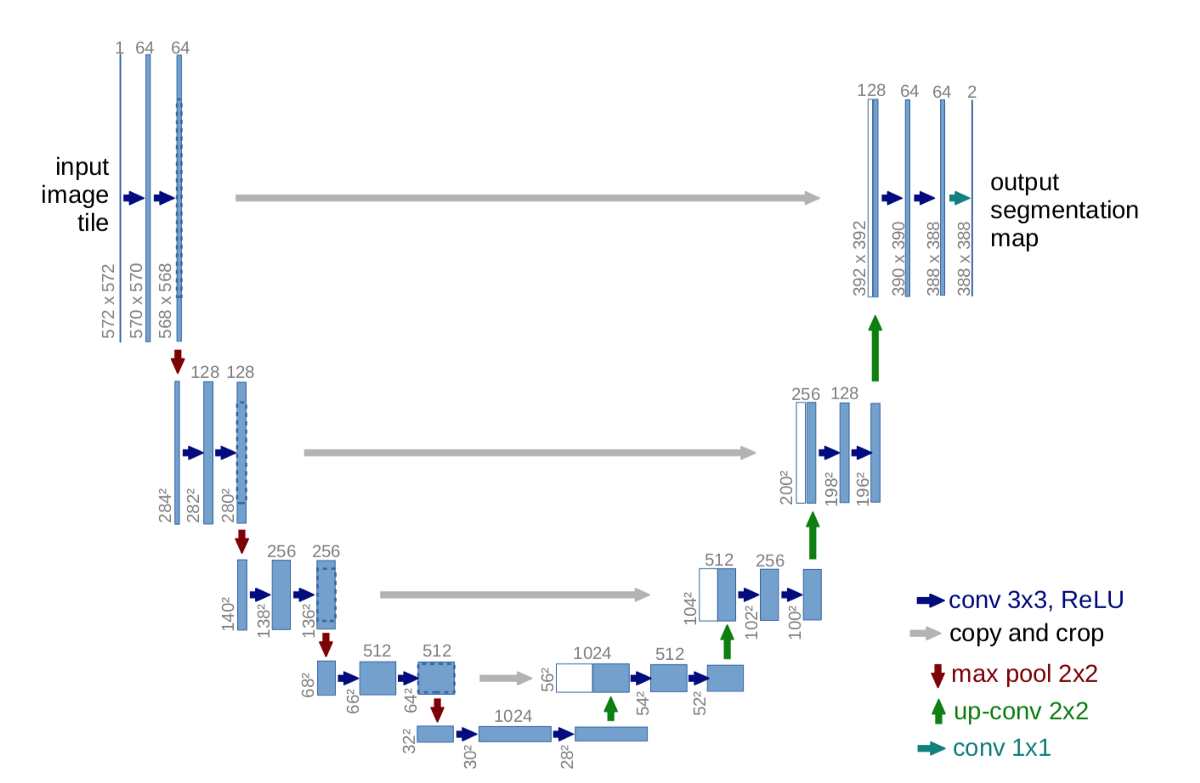

In [ ]:
model1_unet = load_model("/content/drive/MyDrive/Colab Notebooks/Model1_Unet_BrainMriSeg.h5",custom_objects={"focal_tversky":focal_tversky,"tversky":tversky,"tversky_loss":tversky_loss})

test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))
results = model1_unet.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 20s 202ms/step - loss: 0.1639 - tversky: 0.9095


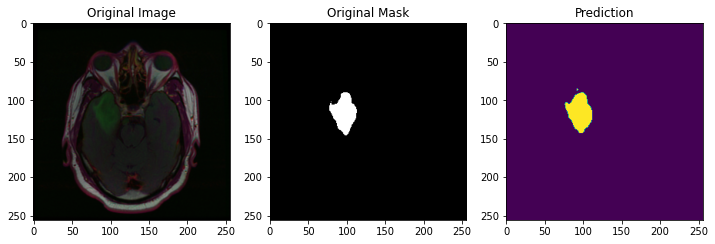

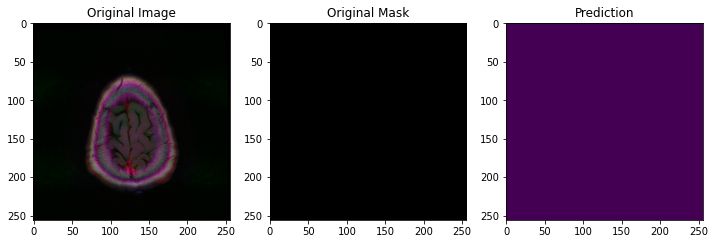

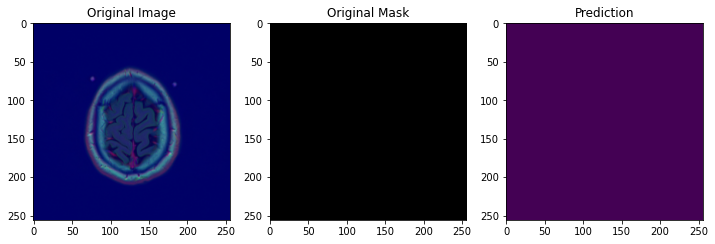

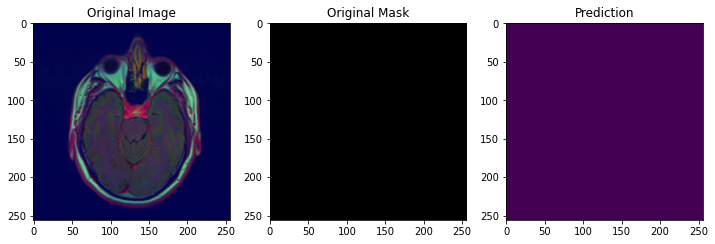

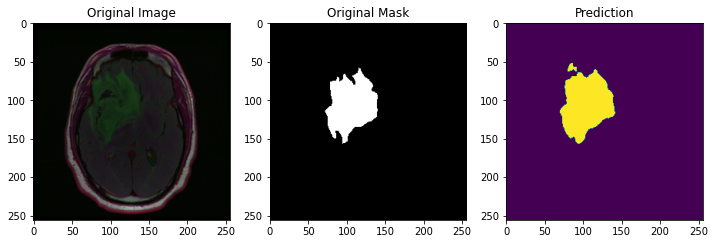

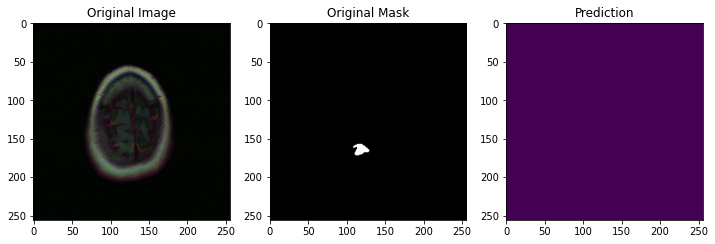

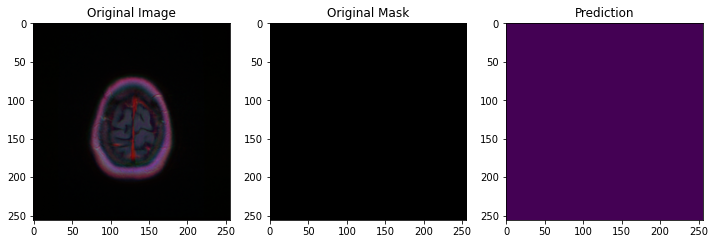

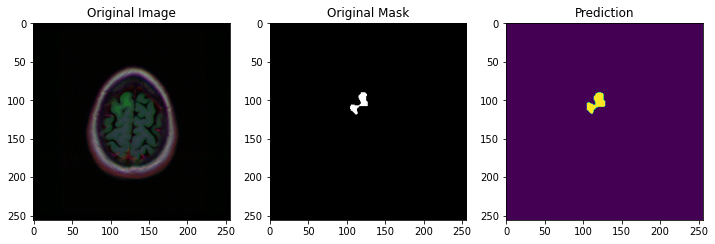

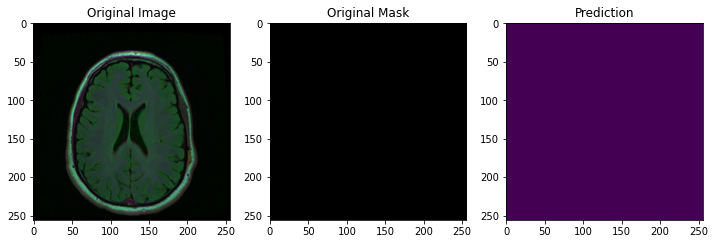

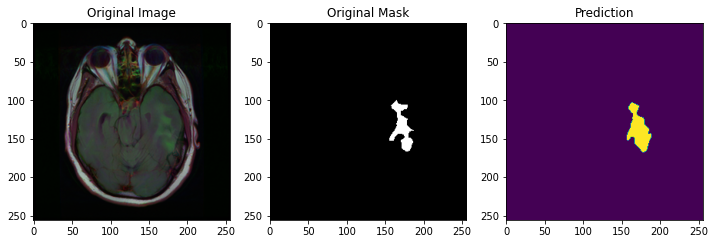

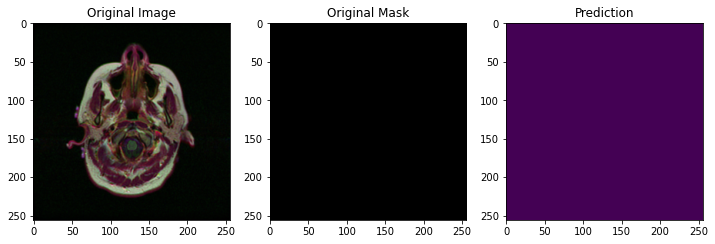

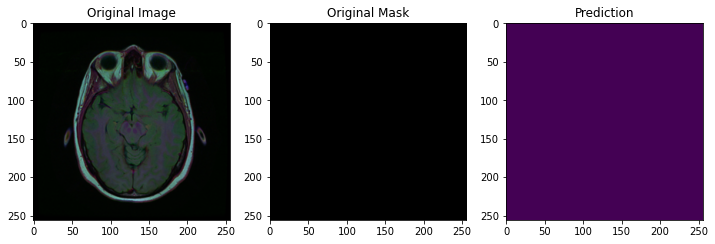

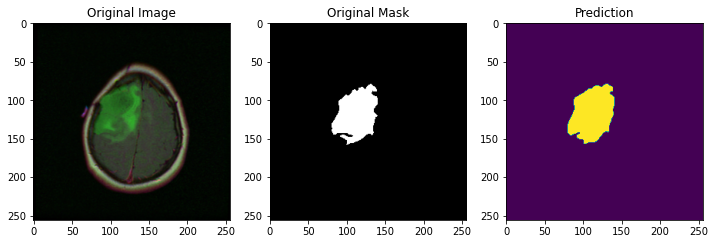

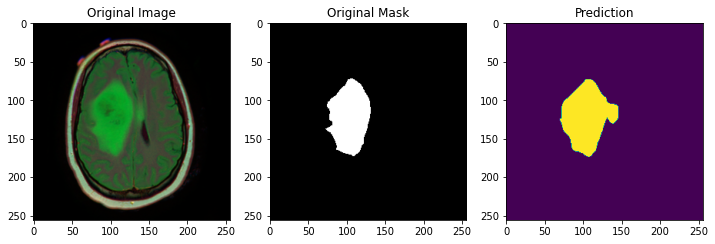

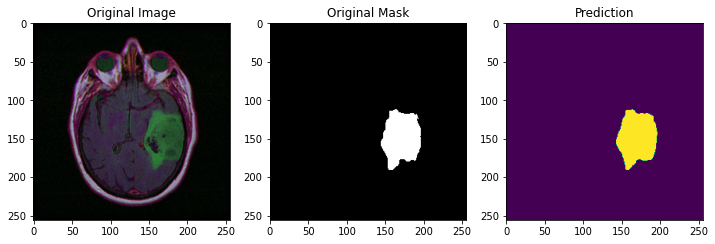

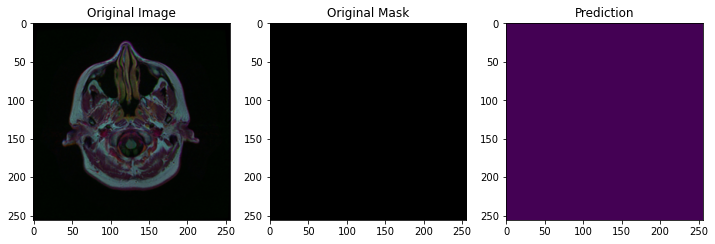

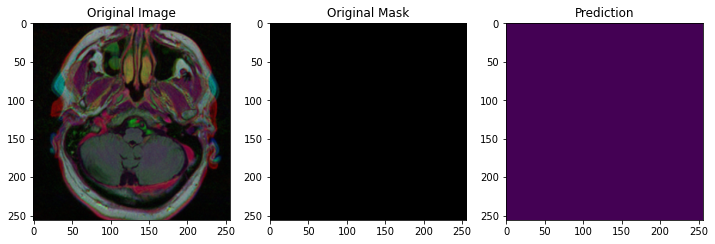

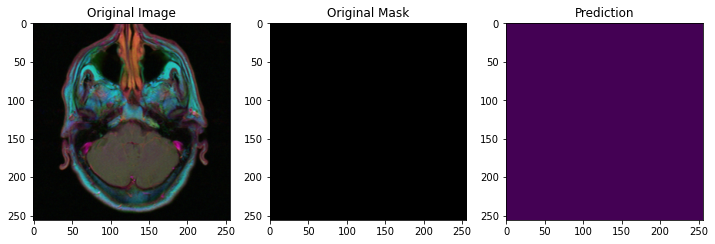

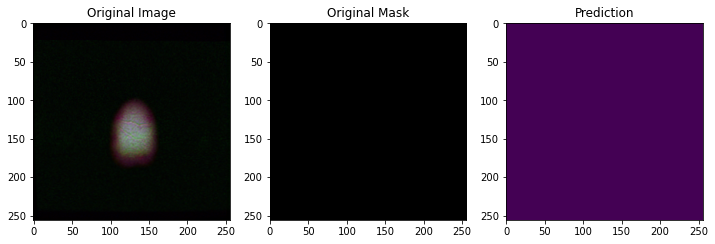

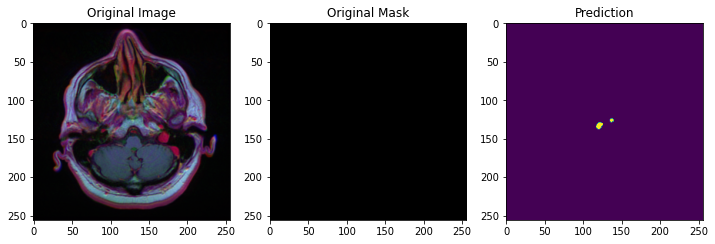

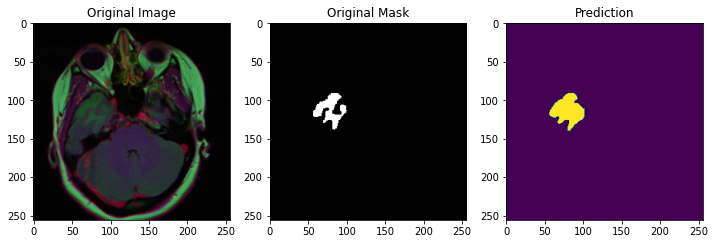

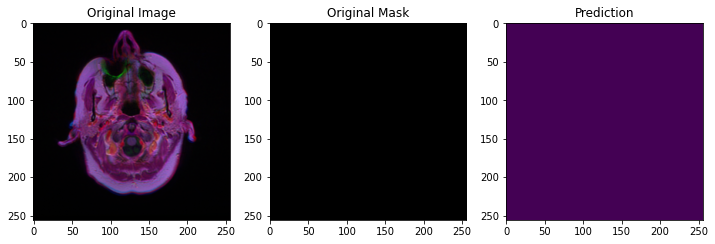

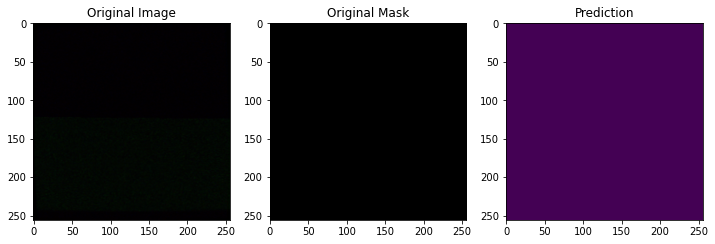

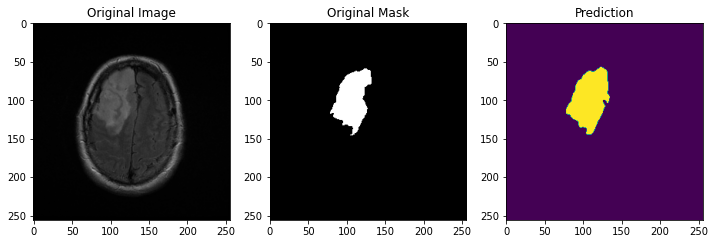

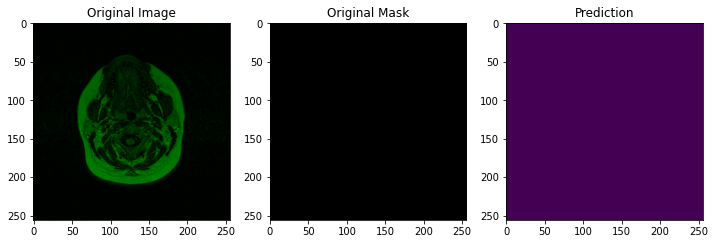

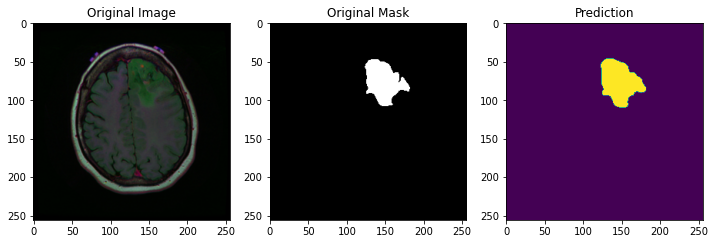

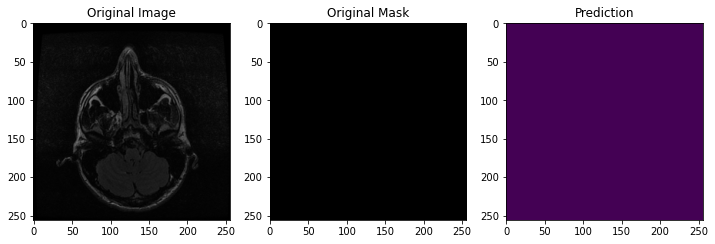

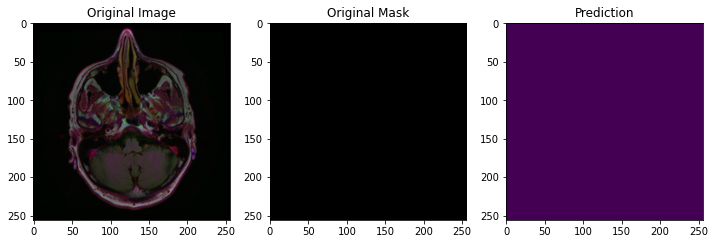

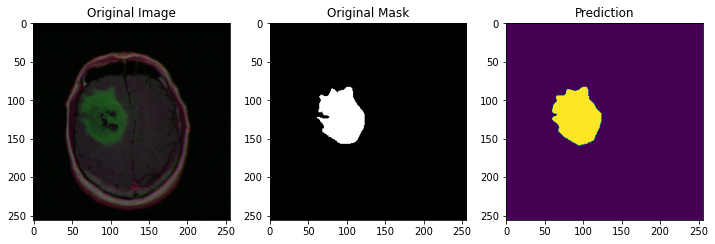

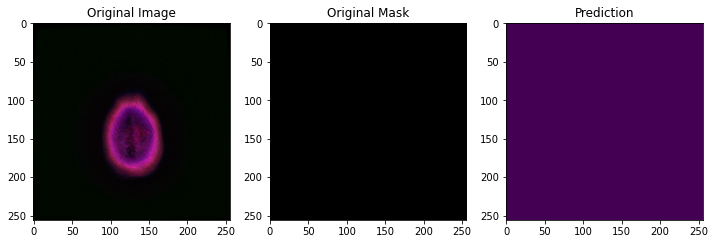

In [ ]:
model_result(model1_unet,df_test)